In [1]:
## Load Dataset & Pretrained Model

import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

mdata = pd.read_excel("/kaggle/input/trump-tweet-dataset/tweets.xlsx")
mdata = mdata[mdata["is_retweet"] == False]
mdata = mdata.drop(["RanNum", "CenNum", "created_at"], axis=1)

# Column Description:
# source: Media Studio/Twitter Ads/Twitter for Android/Twitter for iPad/Twitter for iPhone/Twitter Media Studio/Twitter Web Client (one-hot vectors)
# retweet_count: non-negative integer
# favorite_count: non-negative integer (equal to 0 if is_retweet = TRUE)
# is_retweet: TRUE/FALSE (0/1 variable) (filter only TRUE)
# HSTG: 0/1
# ATSN: 0/1
# CRIT: 0/1 (one N/A, row 1882 in excel)
# MEDI: 0/1
# FAMY: 0/1 (one N/A, row 1531 in excel)
# PLCE: 0/1
# MAGA: 0/1
# CAPT: 0/1
# INDV: 0/1/2 (one-hot vectors)
# MARG: 0/1 (one N/A, row 441 in excel)
# INTN: 0/1
# PRTY: 0/1/2/3 (one-hot vectors)
# IMMG: 0/1 (one N/A, row 830 in excel)
# text: cleaning -> embeddings -> PCA (processed with other variables/treated independently)

In [2]:
## Clean Text

import re
import html

def clean_text(txt):
    txt = html.unescape(txt)
    txt = re.sub(r"http\S+", "<URL>", txt)
    return txt

mdata["text"] = mdata["text"].apply(clean_text)

In [3]:
## Drop NA, Data Type, One-Hot

mdata = mdata.dropna()
mdata = mdata.astype({
    "CRIT": "int",
    "FAMY": "int",
    "MARG": "int",
    "IMMG": "int"
})
ext_data = pd.get_dummies(mdata, columns=["source", "INDV", "PRTY"])
bool_cols = ext_data.select_dtypes(include=bool).columns
ext_data[bool_cols] = ext_data[bool_cols].astype(int)

mdata = mdata.reset_index(drop=False)

In [5]:
ext_data = ext_data.reset_index(drop=True)

In [6]:
## Text to Embedding

embed_model = SentenceTransformer("all-MiniLM-L6-v2")
# embed_model.eval()
embeddings = embed_model.encode(ext_data["text"])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/57 [00:00<?, ?it/s]

In [7]:
## PCA (Text Only)

# from sklearn.preprocessing import normalize
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# pca = PCA(n_components=80)
# embeddings_pca = pca.fit_transform(embeddings)

# print(pca._fit_svd_solver, np.sum(pca.explained_variance_ratio_))

from mlxtend.feature_extraction import PrincipalComponentAnalysis

pca = PrincipalComponentAnalysis(n_components=15)
pca.fit(embeddings)
embeddings_pca = pca.transform(embeddings)

embeddings_pca = np.load("embedding_pca.npy")

## Concatenate Variables & Preprocessing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, RobustScaler

X = ext_data.drop("text", axis=1)
pipe = Pipeline([
    ("log1p", FunctionTransformer(np.log1p, validate=True)),
    ("robust", RobustScaler())
])
X["retweet_count"] = pipe.fit_transform(X[["retweet_count"]])
X["favorite_count"] = pipe.fit_transform(X[["favorite_count"]])

# X_np = np.hstack([X.values, embeddings_pca])
X_np = embeddings_pca

X_np.shape

(1805, 30)

In [ ]:
## Save Embedding

# np.save("embedding_pca.npy", X_np)

In [ ]:
## PCA (All)

# X = ext_data.drop("text", axis=1)
# pipe = Pipeline([
#     ("log1p", FunctionTransformer(np.log1p, validate=True)),
#     ("robust", RobustScaler())
# ])
# X["retweet_count"] = pipe.fit_transform(X[["retweet_count"]])
# X["favorite_count"] = pipe.fit_transform(X[["favorite_count"]])

# X_np = np.hstack([X.values, embeddings])

# pca = PCA(n_components=1)
# X_np = pca.fit_transform(X_np)

# np.sum(pca.explained_variance_ratio_)

In [ ]:
import hdbscan
from sklearn.metrics.pairwise import cosine_distances

clusterer = hdbscan.HDBSCAN(min_cluster_size=20, metric="euclidean")
labels = clusterer.fit_predict(X_np)
X["cluster"] = labels

X["cluster"].value_counts()

# DIED

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=37, n_init=20)
labels = kmeans.fit_predict(X_np)
X["cluster"] = labels

print(X["cluster"].value_counts())

cluster_id = 6

output_id = X[X["cluster"] == cluster_id].index.tolist()
output = X.loc[output_id].copy()
output["text"] = mdata.loc[output_id, "text"].values

# output["text"].tolist()

cluster
5    249
3    240
6    238
8    217
0    190
9    169
1    156
2    148
4    122
7     76
Name: count, dtype: int64


In [11]:
## Evaluate China

cluster_num = 10

CN_regex = "China|Beijing|Xi"
KP_regex = "North Korea|Kim Jong|Kim Prepared|Chairman Kim"
RU_regex = "Russia|Putin"
agg_regex = f"{CN_regex}|{KP_regex}|{RU_regex}"

CN_num = [0] * cluster_num
CN_freq = [0] * cluster_num
KP_num = [0] * cluster_num
KP_freq = [0] * cluster_num
RU_num = [0] * cluster_num
RU_freq = [0] * cluster_num
agg_num = [0] * cluster_num
agg_freq = [0] * cluster_num

for cluster_id in range(cluster_num):
    output_id = X[X["cluster"] == cluster_id].index.tolist()
    output = X.loc[output_id].copy()
    output["text"] = mdata.loc[output_id, "text"].values
    CN_num[cluster_id] = output["text"].str.contains(CN_regex, case=True).sum()
    CN_freq[cluster_id] = CN_num[cluster_id] / output.shape[0]
    KP_num[cluster_id] = output["text"].str.contains(KP_regex, case=True).sum()
    KP_freq[cluster_id] = KP_num[cluster_id] / output.shape[0]
    RU_num[cluster_id] = output["text"].str.contains(RU_regex, case=True).sum()
    RU_freq[cluster_id] = RU_num[cluster_id] / output.shape[0]
    agg_num[cluster_id] = output["text"].str.contains(agg_regex, case=True).sum()
    agg_freq[cluster_id] = agg_num[cluster_id] / output.shape[0]

pd_out = pd.DataFrame(index=range(1, cluster_num + 1))
pd_out["CN num"], pd_out["CN freq"] = CN_num, CN_freq
pd_out["KP num"], pd_out["KP freq"] = KP_num, KP_freq
pd_out["RU num"], pd_out["RU freq"] = RU_num, RU_freq
pd_out["Agg num"], pd_out["Agg freq"] = agg_num, agg_freq

pd_out

CN num   CN freq  KP num   KP freq  RU num   RU freq  Agg num  Agg freq
1       18  0.094737      42  0.221053      26  0.136842       70  0.368421
2        0  0.000000       0  0.000000       0  0.000000        0  0.000000
3        2  0.013514       2  0.013514      14  0.094595       17  0.114865
4        3  0.012500       1  0.004167       0  0.000000        4  0.016667
5        1  0.008197       0  0.000000       0  0.000000        1  0.008197
6        2  0.008032       0  0.000000      57  0.228916       58  0.232932
7        0  0.000000       0  0.000000       0  0.000000        0  0.000000
8        0  0.000000       0  0.000000       0  0.000000        0  0.000000
9       17  0.078341       0  0.000000       1  0.004608       18  0.082949
10       0  0.000000       0  0.000000       1  0.005917        1  0.005917

In [3]:
np.savetxt("embeddings_pca.csv", X_np, delimiter=",")

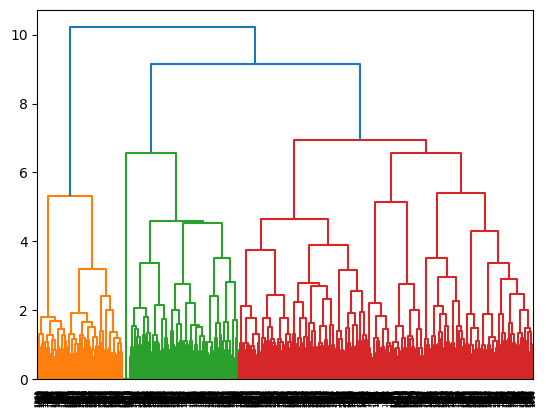

In [18]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_data = linkage(X_np, method='ward', metric='euclidean')
dendrogram(linkage_data)

plt.show()

In [19]:
from scipy.cluster.hierarchy import fcluster

thres = 5.2

clusters_d = pd.Series(fcluster(linkage_data, t=thres, criterion='distance'))

print(clusters_d.value_counts())

clusters_n = clusters_d.nunique()

out = pd.DataFrame(index=range(1, clusters_n + 1))
kv = {"CN": CN_regex, "KP": KP_regex, "RU": RU_regex, "Agg": agg_regex}
for k, v in kv.items():
    out[k] = [mdata[clusters_d == i]["text"].str.contains(v, case=True).sum() for i in range(1, clusters_n + 1)]

out

5    470
4    396
8    250
6    203
2    201
7    149
1    109
3     27
Name: count, dtype: int64


CN  KP  RU  Agg
1   2   2   5    8
2   2   3  67   70
3   0   0   0    0
4   8   9   1   15
5   0   2   7    8
6   0   0   0    0
7  10  28  19   47
8  21   1   0   21

In [ ]:
## Wordclouds (K-means)

from wordcloud import WordCloud

cluster_ids = [
    1, 2, 3, 4, 5,
    21, 22, 23, 24, 25,
    51, 52, 53, 54, 55,
    81, 82, 83, 84, 85
]  

k_clusters = len(cluster_ids)
n_cols = 5
n_rows = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))

type2regex = {
    1: ("Unfiltered", ),
    2: ("CN", CN_regex),
    3: ("KP", KP_regex),
    4: ("RU", RU_regex),
    5: ("Agg", agg_regex),
}

for ax, cid in zip(axes.flat, cluster_ids):
    typeid = cid % 10
    cid = cid // 10
    txts = mdata[X["cluster"] == cid]["text"]
    if len(txts) == 0:
        ax.axis("off")
        continue
    wc_input = "\n".join(txts)
    if typeid != 1:
        wc_input = "\n".join(txts[txts.str.contains(type2regex[typeid][1], case=True)])
    if len(wc_input) == 0:
        wc_input = "NA"
    wordcloud = WordCloud(
        width=400,
        height=300,
        background_color="white"
    ).generate(wc_input)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f"Cluster {cid}, {type2regex[typeid][0]}")
    ax.axis("off")

for ax in axes.flat[k_clusters:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

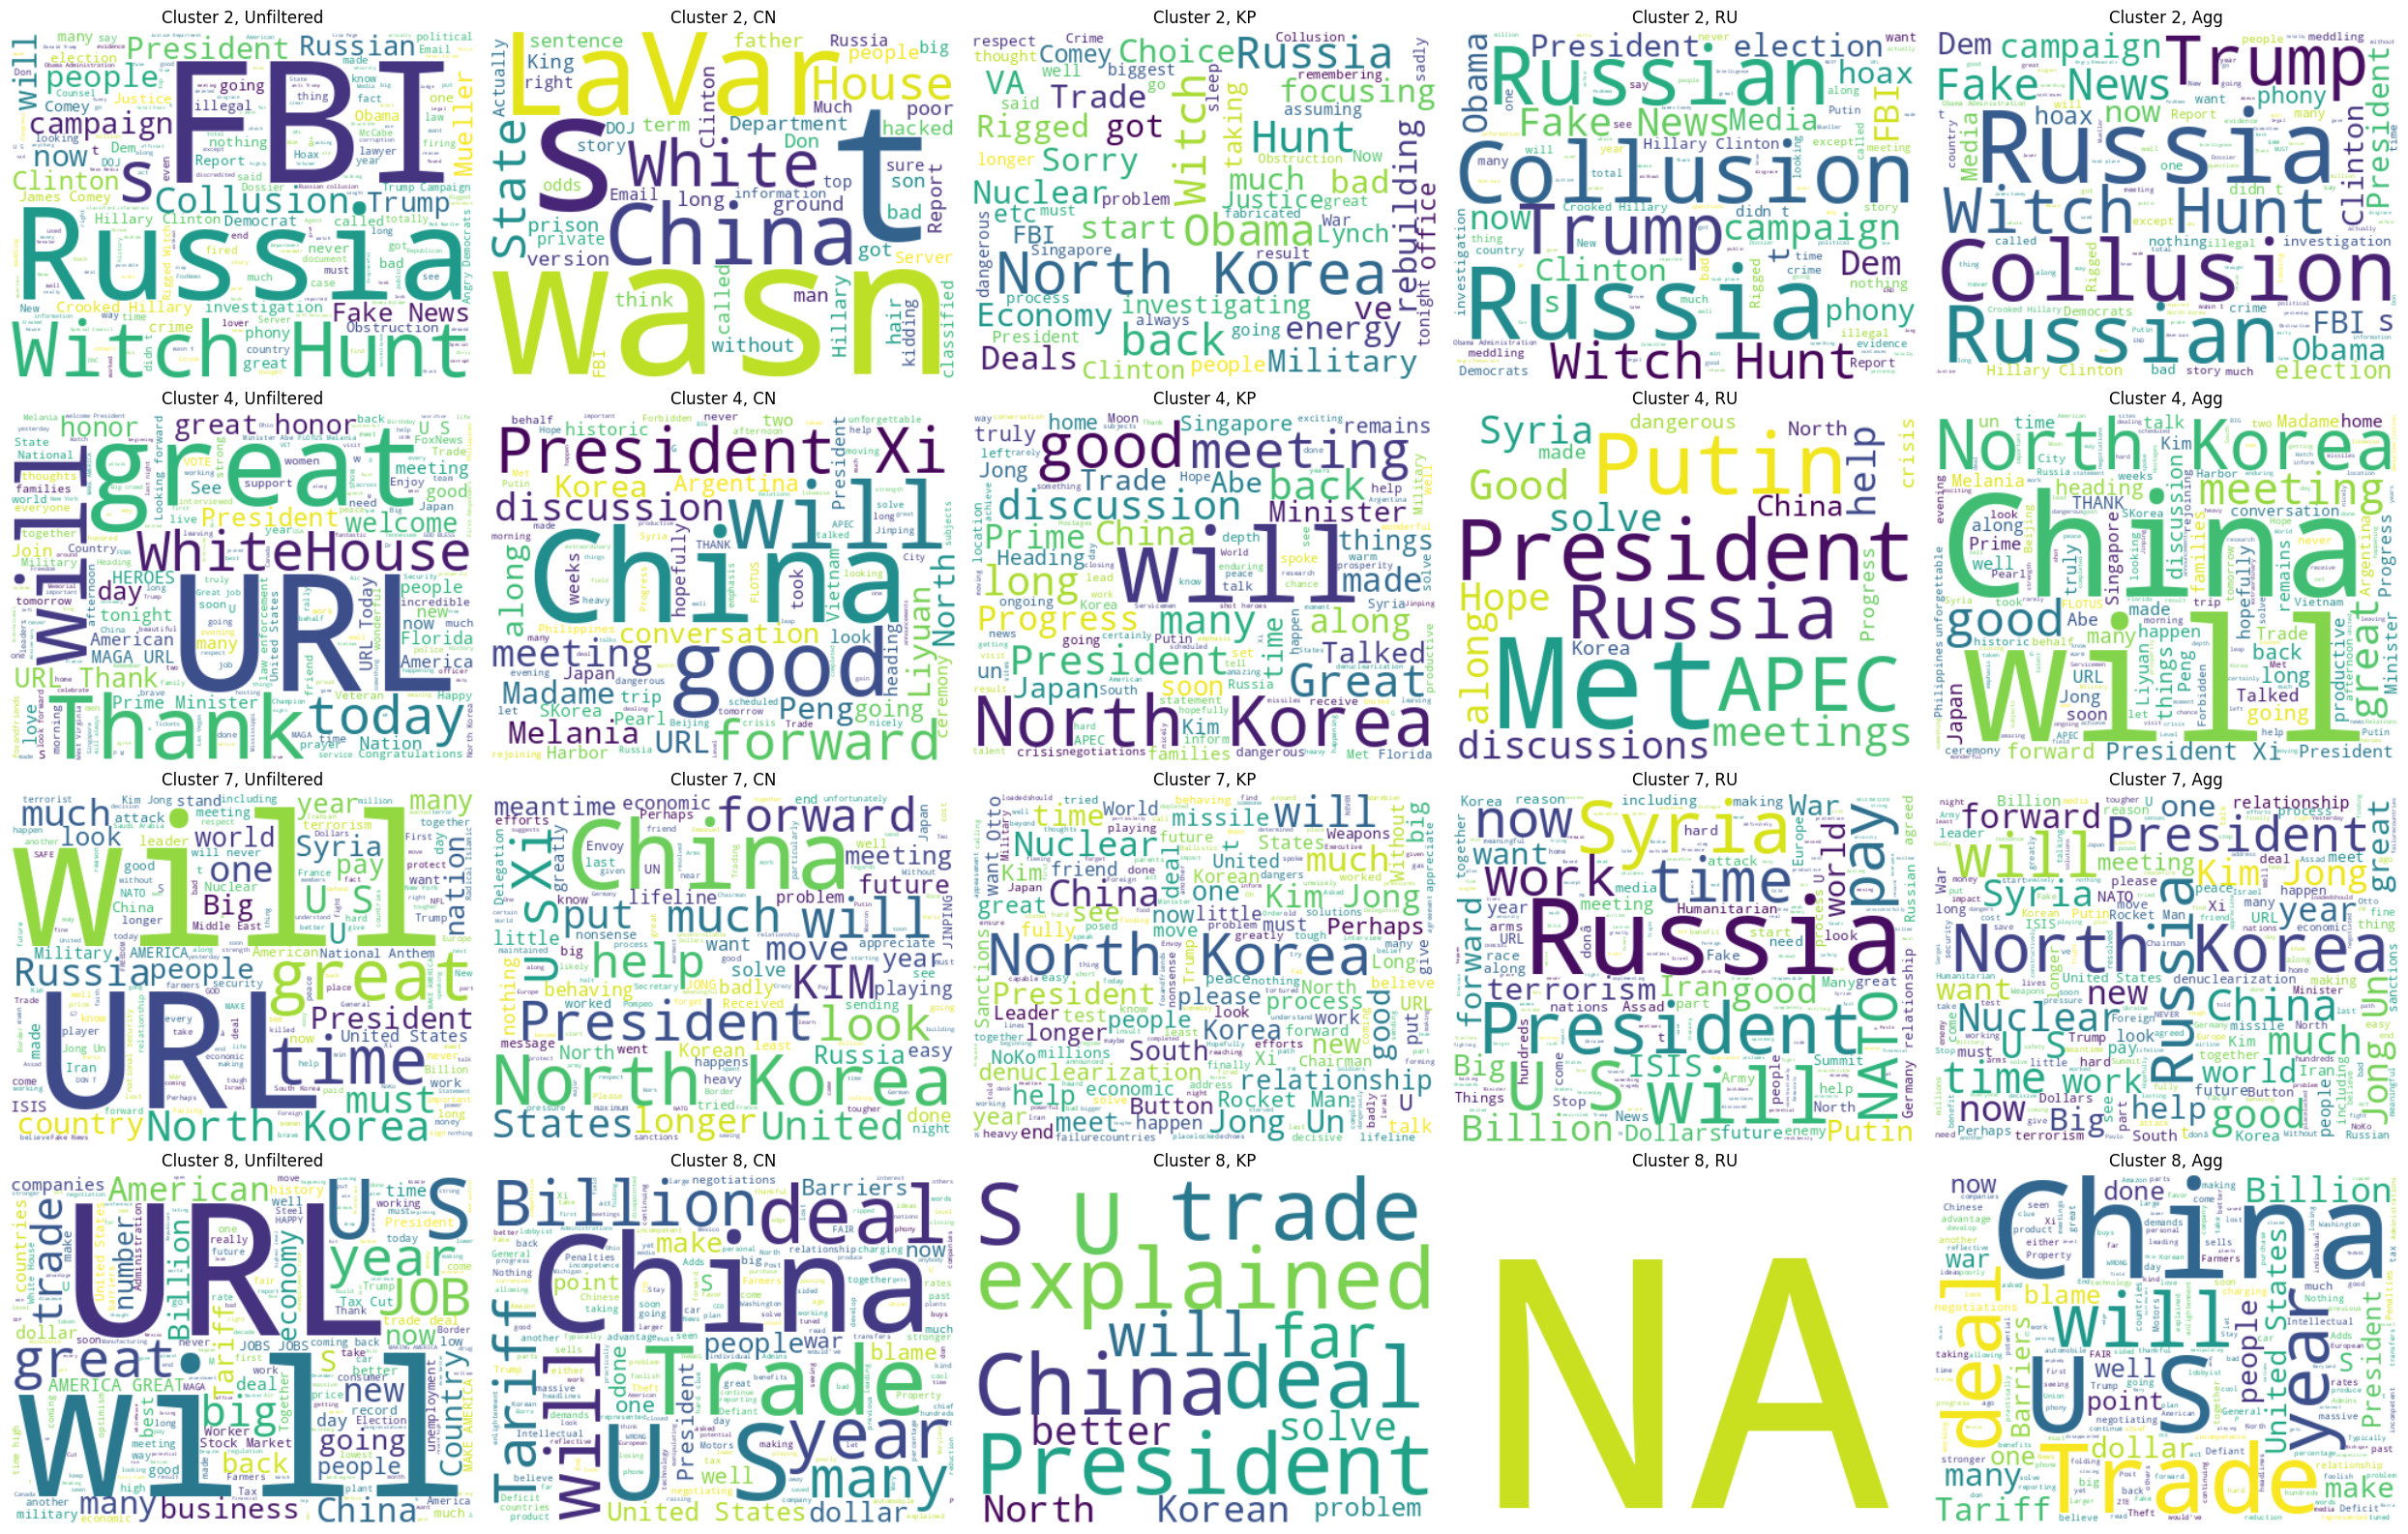

In [13]:
## Wordclouds (Hierarchical Clustering)

from wordcloud import WordCloud

cluster_ids = [
    21, 22, 23, 24, 25,
    41, 42, 43, 44, 45,
    71, 72, 73, 74, 75,
    81, 82, 83, 84, 85
]

k_clusters = len(cluster_ids)
n_cols = 5
n_rows = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))

type2regex = {
    1: ("Unfiltered", ),
    2: ("CN", CN_regex),
    3: ("KP", KP_regex),
    4: ("RU", RU_regex),
    5: ("Agg", agg_regex),
}

for ax, cid in zip(axes.flat, cluster_ids):
    typeid = cid % 10
    cid = cid // 10
    txts = mdata[clusters_d == cid]["text"]
    if len(txts) == 0:
        ax.axis("off")
        continue
    wc_input = "\n".join(txts)
    if typeid != 1:
        wc_input = "\n".join(txts[txts.str.contains(type2regex[typeid][1], case=True)])
    if len(wc_input) == 0:
        wc_input = "NA"
    wordcloud = WordCloud(
        width=400,
        height=300,
        background_color="white"
    ).generate(wc_input)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f"Cluster {cid}, {type2regex[typeid][0]}")
    ax.axis("off")

for ax in axes.flat[k_clusters:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
## t-SNE (K-means)

from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, perplexity=20, random_state=37)
# X_2d = tsne.fit_transform(X_np)

# colors = plt.cm.tab10(np.arange(clusters_n))

# for cluster_id in range(1, clusters_n + 1):
#     X_i = X_2d[clusters_d == cluster_id]
#     plt.scatter(X_i[:, 0], X_i[:, 1], c=colors[cluster_id - 1], label=f"Cluster {cluster_id}", s=10)
# plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
# plt.show()

perplexities = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

colors = plt.cm.tab10(np.arange(10))

for ax, perp in zip(axes, perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, random_state=37)
    X_2d = tsne.fit_transform(X_np)

    for cluster_id in range(10):
        X_i = X_2d[X["cluster"] == cluster_id]
        ax.scatter(X_i[:, 0], X_i[:, 1], 
                   c=[colors[cluster_id]], 
                   label=f"Cluster {cluster_id}", s=10)
    
    ax.set_title(f"t-SNE (perplexity={perp})")
    ax.set_xticks([])
    ax.set_yticks([])

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Perplexity = 50

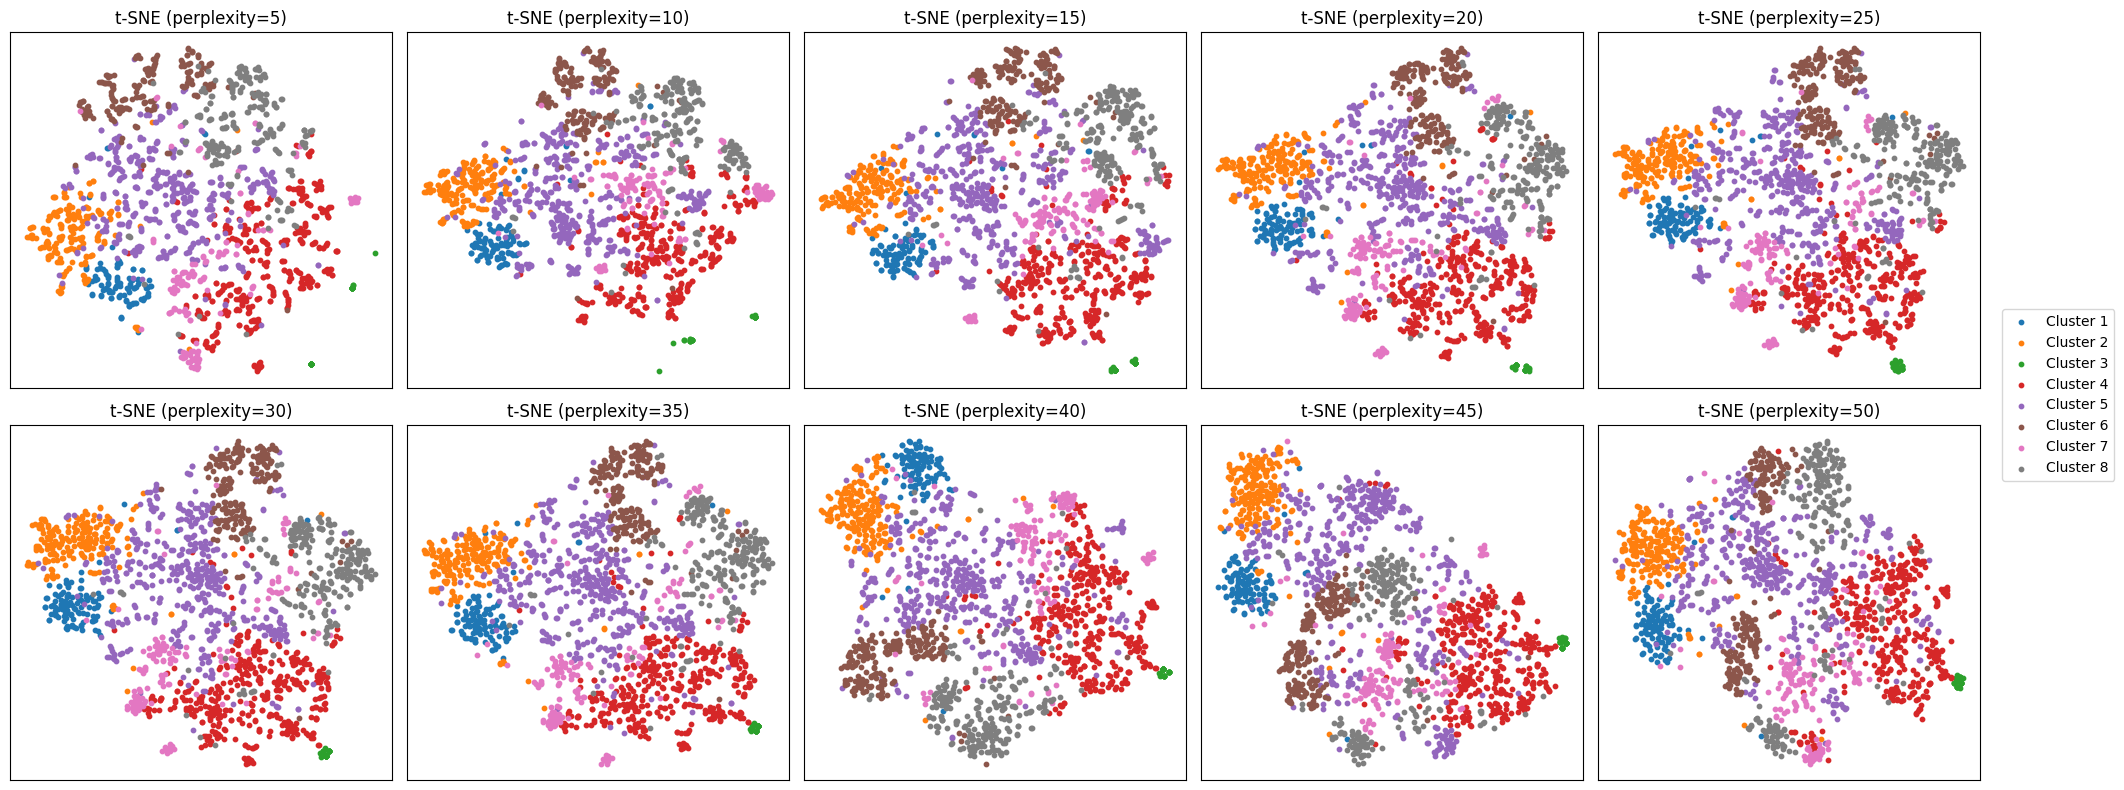

In [15]:
## t-SNE (Hierarchical Clustering)

from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, perplexity=20, random_state=37)
# X_2d = tsne.fit_transform(X_np)

# colors = plt.cm.tab10(np.arange(clusters_n))

# for cluster_id in range(1, clusters_n + 1):
#     X_i = X_2d[clusters_d == cluster_id]
#     plt.scatter(X_i[:, 0], X_i[:, 1], c=colors[cluster_id - 1], label=f"Cluster {cluster_id}", s=10)
# plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
# plt.show()

perplexities = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

colors = plt.cm.tab10(np.arange(clusters_n))

for ax, perp in zip(axes, perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, random_state=37)
    X_2d = tsne.fit_transform(X_np)

    for cluster_id in range(1, clusters_n + 1):
        X_i = X_2d[clusters_d == cluster_id]
        ax.scatter(X_i[:, 0], X_i[:, 1], 
                   c=[colors[cluster_id - 1]], 
                   label=f"Cluster {cluster_id}", s=10)
    
    ax.set_title(f"t-SNE (perplexity={perp})")
    ax.set_xticks([])
    ax.set_yticks([])

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


In [ ]:
## t-SNE 3D

import plotly.graph_objects as go
import plotly.express as px

tsne = TSNE(n_components=3, perplexity=20, random_state=37)
X_3d = tsne.fit_transform(X_np)

clusters_n = len(np.unique(clusters_d))
colors = px.colors.qualitative.Plotly

fig = go.Figure()

for cluster_id in range(clusters_n):
    X_i = X_3d[clusters_d == cluster_id + 1]
    fig.add_trace(go.Scatter3d(
        x=X_i[:, 0], y=X_i[:, 1], z=X_i[:, 2],
        mode='markers',
        marker=dict(size=3, color=colors[cluster_id % len(colors)]),
        name=f"Cluster {cluster_id + 1}"
    ))

fig.update_layout(
    scene=dict(
        xaxis_title="t-SNE 1",
        yaxis_title="t-SNE 2",
        zaxis_title="t-SNE 3"
    ),
    legend=dict(x=1, y=0.5)
)

fig.show()


In [14]:
## Percentage Table for Other Variables (Hierarchical Clustering)

var_row = ext_data.drop(["retweet_count", "favorite_count", "is_retweet", "text"], axis=1).columns

other_var_result = pd.DataFrame(index=var_row)

for i in (1, 2, 3, 4, 5, 6, 7, 8):
    ins_col = []
    for varname in var_row:
        siz = (clusters_d == i).sum()
        ins_col.append((ext_data[clusters_d == i][varname] == 1).sum() / siz * 100)
    other_var_result[f"Cluster {i}"] = ins_col

tab_percentage = other_var_result[~var_row.str.startswith("source")].loc[["MAGA","CRIT", "MEDI", "INDV_1", "INTN", "PRTY_1", "PRTY_2", "IMMG"]]
tab_percentage

Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 5  Cluster 6  \
MAGA     2.752294   0.497512        0.0   9.090909   4.042553   0.492611   
CRIT    89.908257  88.059701        0.0   3.535354  50.425532  70.443350   
MEDI    92.660550  12.437811        0.0   0.252525   7.021277   2.463054   
INDV_1  27.522936  74.129353        0.0  37.878788  62.340426  21.674877   
INTN    11.009174  34.328358        0.0  25.252525   8.936170   8.866995   
PRTY_1   2.752294   1.990050        0.0   0.252525   4.042553   9.359606   
PRTY_2   4.587156  18.905473        0.0   0.000000  13.829787  32.019704   
IMMG     0.000000   0.497512        0.0   1.262626  10.000000  62.561576   

        Cluster 7  Cluster 8  
MAGA     3.355705       10.4  
CRIT    44.966443       26.0  
MEDI     5.369128        2.8  
INDV_1  24.161074        8.8  
INTN    59.060403       22.4  
PRTY_1   0.000000        2.4  
PRTY_2   2.013423        0.8  
IMMG     2.684564        4.0

In [ ]:
## Export Cluster

for cluster_id in range(1, 9):
    mdata[clusters_d == cluster_id]["text"].to_csv(f"HC_{cluster_id}_text.csv", index=False, header=None, encoding="utf-16")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_36/3995811765.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(scores, fill=True, color='skyblue', bw_adjust=0.5, ax=axes[i])


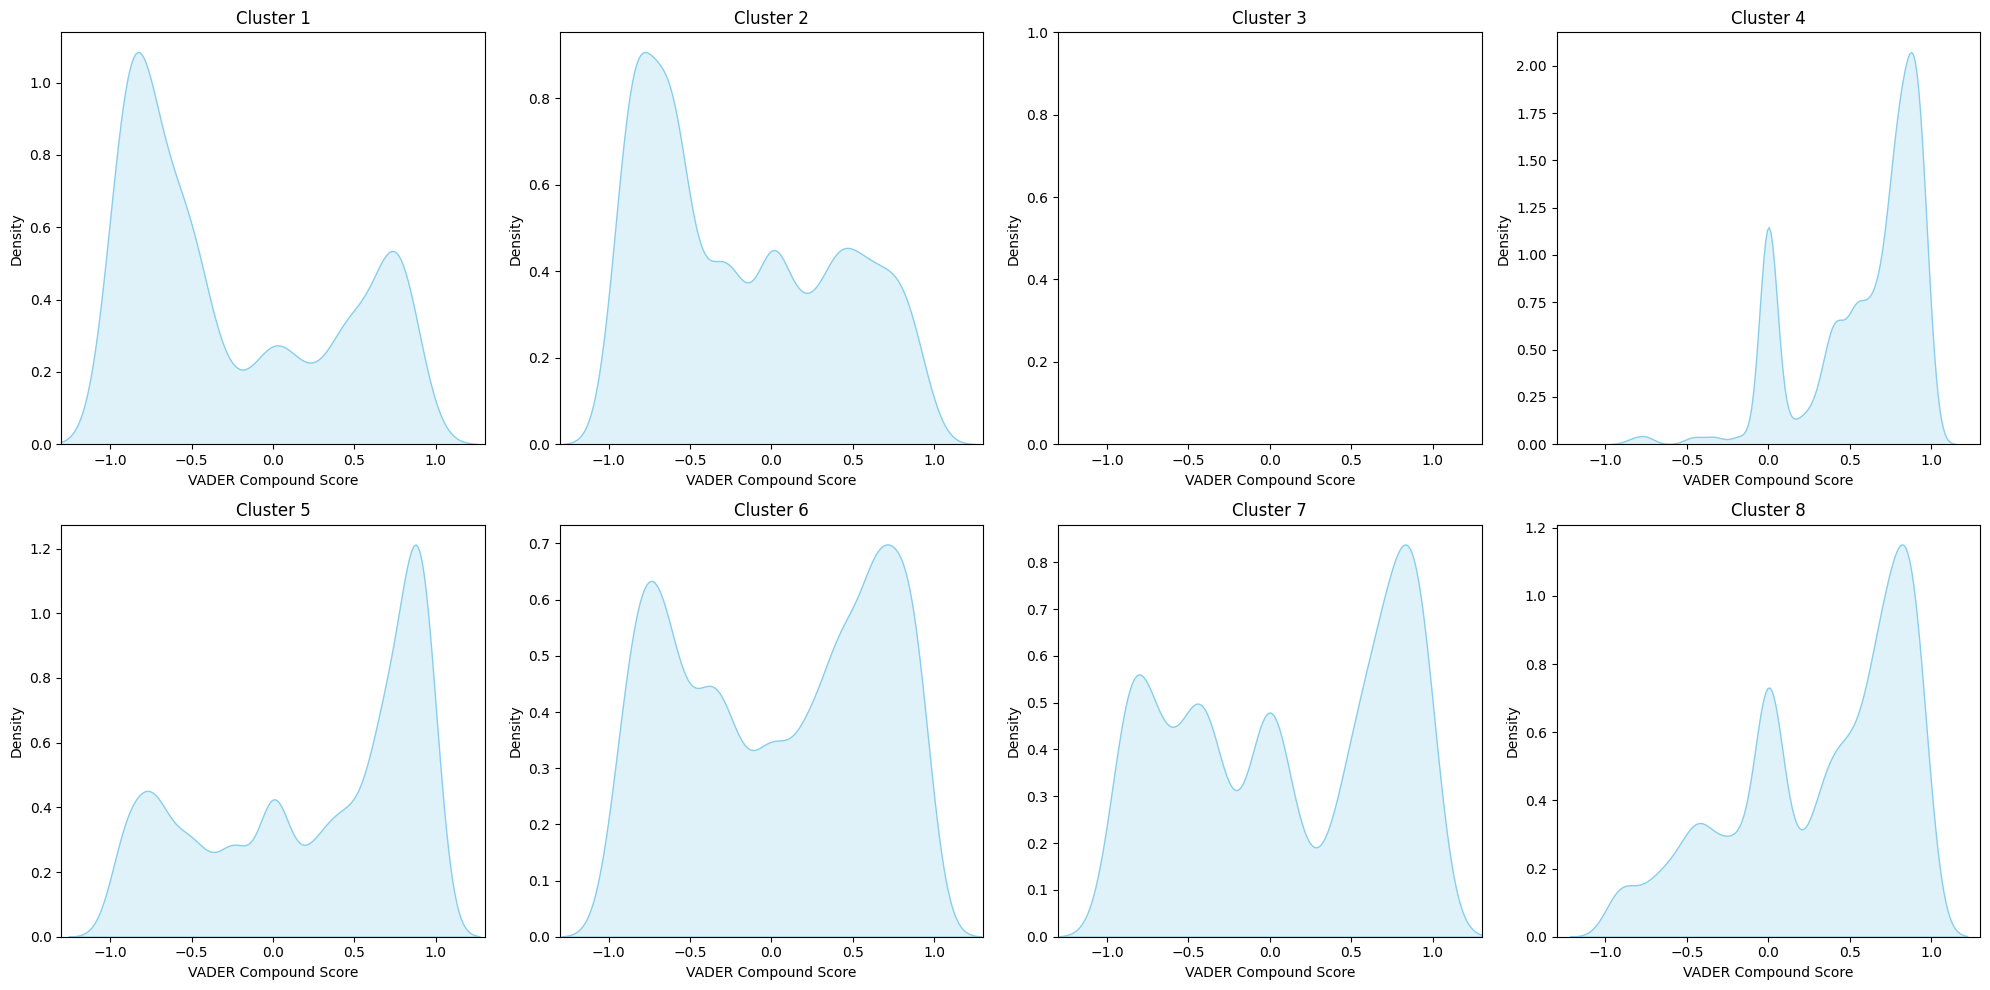

In [18]:
## Sentiment Score (Visualization using ridgeline plot by R)

%pip install vaderSentiment --quiet

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

import seaborn as sns

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

cluster_ids = range(1, 9)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

all_data = []

for i, cluster_id in enumerate(cluster_ids):
    txts = mdata[clusters_d == cluster_id]["text"]
    scores = [analyzer.polarity_scores(t)['compound'] for t in txts]

    for t in txts:
        score = analyzer.polarity_scores(t)['compound']
        all_data.append([cluster_id, t, score])
    
    sns.kdeplot(scores, fill=True, color='skyblue', bw_adjust=0.5, ax=axes[i])
    
    axes[i].set_title(f"Cluster {cluster_id}")
    axes[i].set_xlabel("VADER Compound Score")
    axes[i].set_ylabel("Density")
    axes[i].set_xlim(-1.3, 1.3)

plt.tight_layout()
plt.show()

df_sent = pd.DataFrame(all_data, columns=["cluster", "text", "compound"])
df_sent.to_csv("sentiment_cluster.csv", index=False)